# Comparing counterfactals

In these examples, we will explore counterfactual explanations of time series classifiers. The goal of counterfactual explanations is to highlight the changes required to transform a time series predicted as a particular class to a time series as predicted as another class, i.e., showing the changes required to change the predictors outcome.

In [3]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import (
    counterfactuals,
    ShapeletForestCounterfactual,
    KNeighborsCounterfactual,
    PrototypeCounterfactual,
)

random_state = 1234


As usual, the first step is to load a dataset and split it into training and testing partitions.

In [11]:
x, y = load_dataset("TwoLeadECG")

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=random_state
)
label = np.unique(y_train)[0]
x_test_sample = x_test[y_test != label][:2]


Next, we will explore counterfactual explanations for three classifiers

* ``RandomShapeletForest``
* ``KNearestNeighborsClassifier``
* and, the traditional, ``RandomForestClassifier``

We explore couterfactuals computed for the random shapelet forest as computed by the local counterfactual algorithm. Note that the ``metric="euclidean"`` is required for this counterfactual method.

In [13]:
clf = ShapeletForestClassifier(
    metric="euclidean", random_state=random_state, n_estimators=100
)
clf.fit(x_train, y_train)


ShapeletForestClassifier(random_state=1234)

Second, we fit the counterfactual explanation to the given estimator.

In [28]:
explain = ShapeletForestCounterfactual(random_state=random_state)
explain.fit(clf)

ShapeletForestCounterfactual(random_state=1234)

When predicting, the shapelet forest accurately predict the samples as label 2.

In [29]:
clf.predict(x_test_sample)

array([2., 2.], dtype=float32)

In an effort to explain those predictions, we exploit the counterfactual engine to transform the samples to the desired label (1 in the example). Note that the ``transform``-function, expects one or more samples and one or more *desired* outcomes. Below, we want all samples to be explained as 1, so we simply broadcast the scalar to an array with as many rows as ``x_test_sample``.

In [30]:
x_counterfactual = explain.transform(
    x_test_sample, np.broadcast_to(label, (x_test_sample.shape[0],))
)

Next, we ensure that the counterfactuals are indeed predicted as the desired label by the classifier we try to explain.

In [31]:
clf.predict(x_counterfactual)

array([1., 1.], dtype=float32)

Finally, we plot the first counterfactual and original time series and find that there are two main regions which we need to change for the prediction to change.

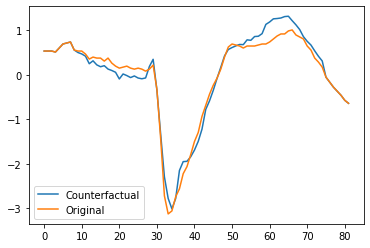

In [32]:
plt.plot(x_counterfactual[0])
plt.plot(x_test_sample[0])
plt.legend(["Counterfactual", "Original"])

Since the counterfactual explanation interface is inconvenient, wildboar has a helper function ``counterfactuals`` which can be used to compute countefactuals for a given estimator.

In [36]:
x_counterfactual, valid, score = counterfactuals(
    clf,
    x_test_sample,
    label,
    scoring="euclidean",
    valid_scoring=True,
    random_state=random_state,
)

We can explore which counterfactuals are valid (i.e., those counterfactuals for which the classifier predicts the desired label).

In [37]:
valid

array([ True,  True])

And, we can also explore the score of the counterfactuals. Here, the scoure is the euclidean distance between the original and counterfactual time series.

In [38]:
score

array([1.6957227 , 1.03749523])

Finally, we can compare the counterfactuals of different methods and plot the output.

/Users/isak/Projects/wildboar/src/wildboar/explain/counterfactual/__init__.py:209: UserWarning: no specific counterfactual explanation method is available for the given estimator. Using a model agnostic estimator.
  warnings.warn(


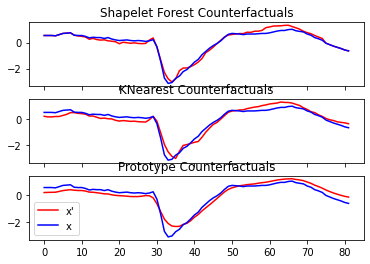

In [39]:
classifiers = [
    (
        "Shapelet Forest Counterfactuals",
        ShapeletForestClassifier(
            metric="euclidean", random_state=random_state, n_estimators=100, n_jobs=-1
        ),
    ),
    ("KNearest Counterfactuals", KNeighborsClassifier(metric="euclidean")),
    ("Prototype Counterfactuals", RandomForestClassifier(random_state=random_state)),
]

fig, ax = plt.subplots(nrows=3, sharex=True)
label = np.unique(y_train)[0]
for i, (name, clf) in enumerate(classifiers):
    clf.fit(x_train, y_train)
    x_test_sample = x_test[y_test != label][:2]
    if isinstance(clf, RandomForestClassifier):
        kwargs = {"train_x": x_train, "train_y": y_train}
    else:
        kwargs = {}

    x_counterfactual, valid = counterfactuals(
        clf, x_test_sample, label, random_state=random_state, method_args=kwargs
    )
    ax[i].set_title(name + ("(invalid)" if not valid[0] else ""))
    ax[i].plot(x_counterfactual[0], c="red")
    ax[i].plot(x_test[0], c="blue")

ax[-1].legend(["x'", "x"])
